# RWJF Open Project Data EDA

## Preamble

In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
#Additional imports
import os
import ratelim
import re
import io
import urllib
import codecs
import bs4
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from nltk.corpus import stopwords

from analysis.src.nlp.lda_pipeline import LdaPipeline, CleanTokenize
from analysis.src.data.readnwrite import get_data_dir

stop = stopwords.words('English')

In [28]:
%matplotlib inline
# Open a standard set of directories

# Paths

# Get the top path
data_path = get_data_dir()
# Create the path for external data
ext_data = os.path.join(data_path, 'external')
# Raw data
raw_data = os.path.join(data_path, 'raw')
# And external data
proc_data = os.path.join(data_path, 'processed')
# And interim data
inter_data = os.path.join(data_path, 'interim')
# And figures
fig_path = os.path.join(data_path, 'figures')

# Get date for saving files
today = datetime.today()

today_str = "_".join([str(x) for x in [today.day,today.month,today.year]])

## 1 Loading and Processing

### 1.1 Load the RWJF scraped data

In [37]:
with open(raw_data+'/rwjf_scraped.json', 'r') as infile:
    rwf = json.load(infile)
    
r_df_messy = pd.concat([pd.Series(x) for x in rwf],axis=1).T

In [38]:
#This is what the data looks like. Note the presence of 'Nones' which we want to turn into nans and
# line breaks \n which we want to turn into spaces
#NB also the presence of apparently redundant columns. How is amount_awarded different from awarded?
r_df_messy.head()

,about,address,amount_awarded,awarded,awarded_on,grant_number,location,organization,page,timeframe,title,topics,website,year
0,None,,None,"$48,924",None,,"Washington, DC",AcademyHealth,2898,None,Academy for Health Services Research and Healt...,None,None,2000
1,None,,None,"$972,460",None,,"Saint Louis, MO",Oasis Institute,2408,None,Active for Life: Increasing Physical Activity ...,Disease Prevention and Health Promotion,None,2003
2,None,,None,"$35,743",None,,"Washington, DC",National Association of County and City Health...,1910,None,Additional steering committee meeting for expl...,Public and Community Health\nBuilt Environment...,None,2005
3,None,,None,"$50,000",None,,"Albany, NY",Social Capital Development Corporation,2988,None,Analyzing data on universal school-based drug ...,Disease Prevention and Health Promotion,None,2000
4,None,,None,"$343,784",None,,"Chicago, IL",National Opinion Research Center (NORC),2838,None,Assessing support for changes in U.S. drug abu...,Disease Prevention and Health Promotion,None,2001


In [39]:
#Get the type of each class. They are mostly strings. We will need to convert the awarded to floats,
#Timeframe or awarded on to dates and so forth.
r_df_messy.dropna(axis=0).iloc[0,:].apply(lambda x: type(x))

about             <class 'str'>
address           <class 'str'>
amount_awarded    <class 'str'>
awarded           <class 'str'>
awarded_on        <class 'str'>
grant_number      <class 'str'>
location          <class 'str'>
organization      <class 'str'>
page              <class 'int'>
timeframe         <class 'str'>
title             <class 'str'>
topics            <class 'str'>
website           <class 'str'>
year              <class 'str'>
Name: 116, dtype: object

In [40]:
#Just checking the formats. Looks like the minimum value that RWJ funds is $50K
r_df_messy.apply(lambda x: x.describe())

,about,address,amount_awarded,awarded,awarded_on,grant_number,location,organization,page,timeframe,title,topics,website,year
count,13025,17686,17572,17686,17572,17686,17686,17686,17686,17572,17686,16699,13780,17686
unique,11942,5460,6852,9145,3919,13135,1506,5809,3607,6503,13026,1076,2873,23
top,The Foundation's Faith in Action: Replication ...,Harvard University T. H. Chan School of Public...,"$50,000","$50,000",12/17/2001,,"Washington, DC","Mathematica Policy Research, Inc.",2368,9/1/2012 - 8/31/2013,Faith in Action,Disease Prevention and Health Promotion,http://www.hsph.harvard.edu/,2001
freq,241,134,850,886,67,114,2175,117,68,75,511,1196,134,1060


In [41]:
#Tidying up. Add missing values
r_df_messy = r_df_messy.applymap(lambda x: np.nan if (x==None) | (x=='') else x)

#Remove \n 
#r_df_messy = r_df_messy.applymap(lambda x: re.sub('\n',' ',x) if type(x)==str else x)

#This is what it looks like now
r_df_messy.head()

,about,address,amount_awarded,awarded,awarded_on,grant_number,location,organization,page,timeframe,title,topics,website,year
0,NaN,NaN,NaN,"$48,924",NaN,NaN,"Washington, DC",AcademyHealth,2898,NaN,Academy for Health Services Research and Healt...,NaN,NaN,2000
1,NaN,NaN,NaN,"$972,460",NaN,NaN,"Saint Louis, MO",Oasis Institute,2408,NaN,Active for Life: Increasing Physical Activity ...,Disease Prevention and Health Promotion,NaN,2003
2,NaN,NaN,NaN,"$35,743",NaN,NaN,"Washington, DC",National Association of County and City Health...,1910,NaN,Additional steering committee meeting for expl...,Public and Community Health\nBuilt Environment...,NaN,2005
3,NaN,NaN,NaN,"$50,000",NaN,NaN,"Albany, NY",Social Capital Development Corporation,2988,NaN,Analyzing data on universal school-based drug ...,Disease Prevention and Health Promotion,NaN,2000
4,NaN,NaN,NaN,"$343,784",NaN,NaN,"Chicago, IL",National Opinion Research Center (NORC),2838,NaN,Assessing support for changes in U.S. drug abu...,Disease Prevention and Health Promotion,NaN,2001


In [42]:
def get_year(date_string):
    '''
    Extracts the year from a date string
    '''
    
    year = int(date_string.split('/')[-1]) if type(date_string)==str else np.nan
    return(year)

In [43]:
#Here we convert the amounts awarded to numbers, the awarded dates and start dates to dates.

r_df_messy['amount_awarded_$'] = r_df_messy['amount_awarded'].apply(lambda x: 
                                                                  int(re.sub(r'[$,]','',x)) if type(x)==str else np.nan)

r_df_messy['awarded_$'] = r_df_messy['awarded'].apply(lambda x: 
                                                                  int(re.sub(r'[$,]','',x)) if type(x)==str else np.nan)

#Topics
r_df_messy['topics'] = r_df_messy['topics'].apply(lambda x: x.split('\n') if type(x)==str else np.nan)

#Years are strings
r_df_messy['year'] = r_df_messy['year'].apply(lambda x: int(x) if type(x)==str else np.nan)


In [44]:
#Select variables
selected_variables = ['grant_number',
            'title','about','topics',
            'organization','address','website','location',
            'year','amount_awarded_$','awarded_$',]


rwj = r_df_messy[selected_variables]

In [45]:
rwj.head()

,grant_number,title,about,topics,organization,address,website,location,year,amount_awarded_$,awarded_$
0,NaN,Academy for Health Services Research and Healt...,NaN,NaN,AcademyHealth,NaN,NaN,"Washington, DC",2000,NaN,48924
1,NaN,Active for Life: Increasing Physical Activity ...,NaN,[Disease Prevention and Health Promotion],Oasis Institute,NaN,NaN,"Saint Louis, MO",2003,NaN,972460
2,NaN,Additional steering committee meeting for expl...,NaN,"[Public and Community Health, Built Environmen...",National Association of County and City Health...,NaN,NaN,"Washington, DC",2005,NaN,35743
3,NaN,Analyzing data on universal school-based drug ...,NaN,[Disease Prevention and Health Promotion],Social Capital Development Corporation,NaN,NaN,"Albany, NY",2000,NaN,50000
4,NaN,Assessing support for changes in U.S. drug abu...,NaN,[Disease Prevention and Health Promotion],National Opinion Research Center (NORC),NaN,NaN,"Chicago, IL",2001,NaN,343784


## 2. Exploratory data analysis

Let's learn more about these data:

* What do different variables mean?
* What are the trends in terms of activity?
* What organisations are being funded?
* In what topics?



### What do the financials mean?

In [46]:
#Amount awarded is present in almost all cases. Is it the same as awarded?
rwj[['amount_awarded_$','awarded_$']].describe()

,amount_awarded_$,awarded_$
count,1.757200e+04,1.768600e+04
mean,4.396720e+05,4.521840e+05
std,1.032603e+06,1.168187e+06
min,1.293000e+03,1.200000e+03
25%,6.500000e+04,6.000000e+04
50%,1.919425e+05,1.920000e+05
75%,4.000000e+05,4.000075e+05
max,2.416750e+07,5.000000e+07


Text(0.5,1,'Amounts awarded vs Awarded')

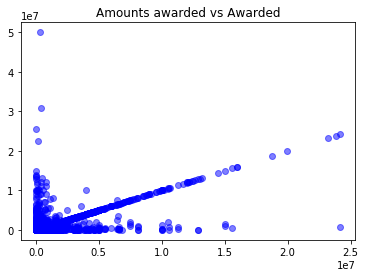

In [50]:
#Let's plot this
plt.scatter(rwj['amount_awarded_$'],rwj['awarded_$'],alpha=0.5,color='blue')
plt.title('Amounts awarded vs Awarded')

TODO: Determine what's happening with these two figures

### What is the situation with missing values?

In [51]:
def missing_props(df,ct=None):
    '''
    Utility function which takes a df and returns missing values in each variable as a % of total.
    If ct!= None this is a variable to crosstab the missing data against
    
    '''
    if ct==None:
        missing = np.round(100*df.apply(lambda x: np.sum(x.isna()))/len(df),3)
        
    if ct!=None:
        missing = {var: df.groupby(ct)[var].apply(lambda x: np.mean(x.isna())) for var in df.columns}
    
    return(missing)

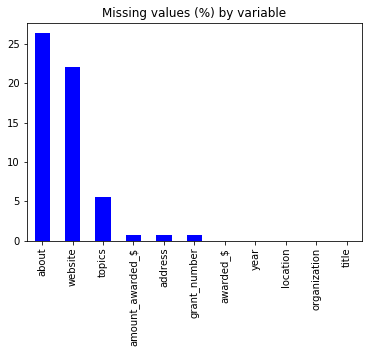

In [52]:
#Plot missing values
missing_props(rwj).sort_values(ascending=False).plot.bar(color='blue',
                                                               title='Missing values (%) by variable')

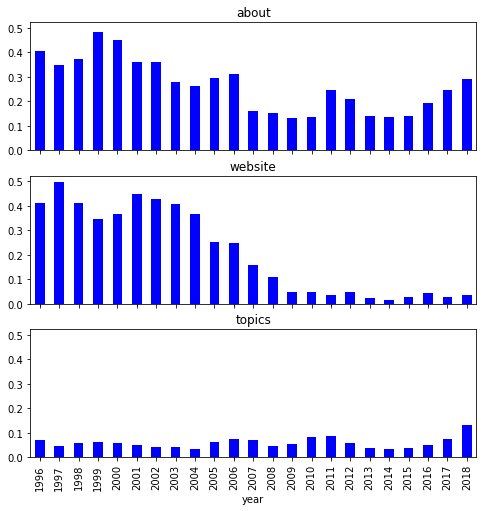

In [53]:
fig,ax = plt.subplots(nrows=3,figsize=(8,8),sharex=True,sharey=True)

missing_props(rwj,'year')['about'].plot.bar(color='blue',ax=ax[0],title='about')
missing_props(rwj,'year')['website'].plot.bar(color='blue',ax=ax[1],title='website')
missing_props(rwj,'year')['topics'].plot.bar(color='blue',ax=ax[2],title='topics')

`About` coverage is not so good. `Website` coverage improves in the last 10 years. 
`topics` coverage has a more or less constant missing rate

**Implications** for now: If we wanted to do an analysis using website data we would need to focus in 2010s or explore sources of bias before 2010.

### Some trends

[None, None, None]

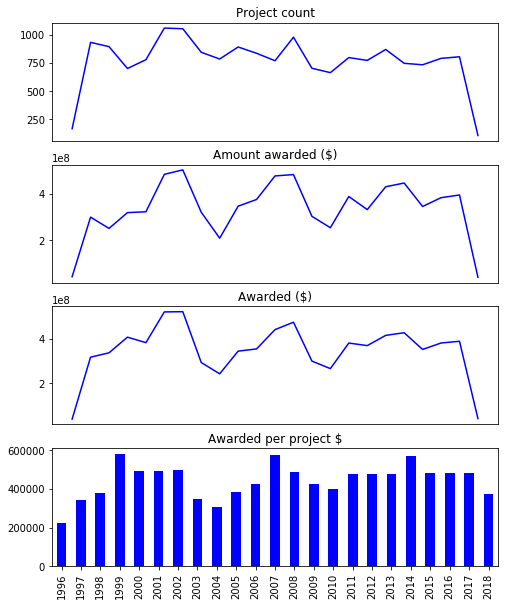

In [54]:
# Number of projects and amounts awarded (including our two measures)

#Create a table with totals raised by year
raised = pd.concat([rwj['year'].value_counts(),rwj.groupby('year')[['amount_awarded_$','awarded_$']].sum()],axis=1)

raised['awarded_per_project'] = raised['awarded_$']/raised['year']

#Plot
fig,ax = plt.subplots(figsize=(8,10),
                      #sharex=True,
                      nrows=4)

raised['year'].plot(ax=ax[0],title='Project count',color='blue')
raised['amount_awarded_$'].plot(ax=ax[1],title='Amount awarded ($)',color='blue')
raised['awarded_$'].plot(ax=ax[2],title='Awarded ($)',color='blue')
raised['awarded_per_project'].plot.bar(ax=ax[3],title='Awarded per project $',color='blue')

[axis.get_xaxis().set_visible(False) for axis in [ax[0],ax[1],ax[2]]]



In [55]:
#Very strong correlation between years
raised.corr(method='pearson')

,year,amount_awarded_$,awarded_$,awarded_per_project
year,1.000000,0.827767,0.872434,0.392252
amount_awarded_$,0.827767,1.000000,0.962797,0.743622
awarded_$,0.872434,0.962797,1.000000,0.766077
awarded_per_project,0.392252,0.743622,0.766077,1.000000


No clear trend in activity. `amount_awarded` and `awarded` have a very strong correlation. They are picking up the same variable

### Top organisations and domains. This will be important for the scraping analysis

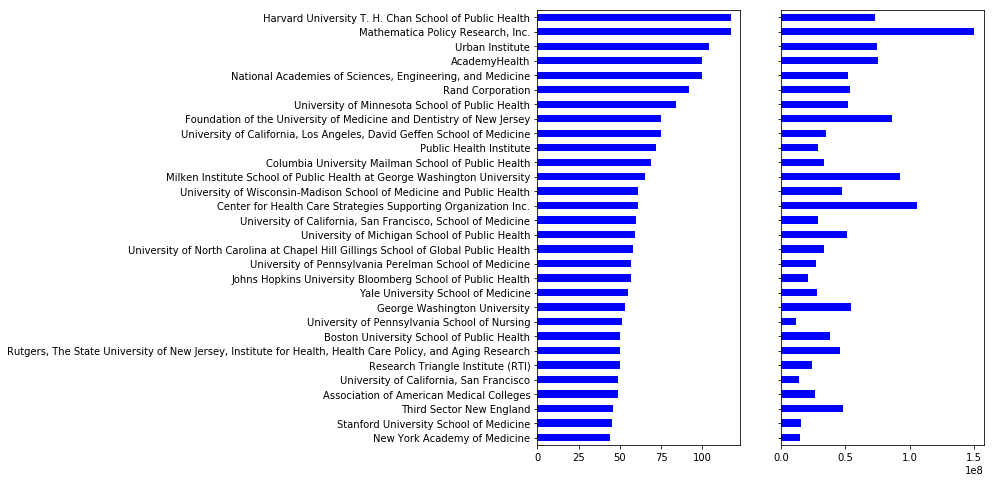

In [56]:
#What are the most 'popular' organisations in the data in terms of number of projects and 
# amounts raised?

#Create a df with the counts / totals raised
org_activity = pd.concat([rwj['organization'].value_counts(),
                          rwj.groupby('organization')['awarded_$'].sum()],axis=1)

#Sort values by number of projects
top_organisations = org_activity.sort_values('organization')[-30:]


#plot
fig,ax = plt.subplots(ncols=2,figsize=(8,8),sharey=True)

top_organisations['organization'].plot.barh(ax=ax[0],color='blue')
top_organisations['awarded_$'].plot.barh(ax=ax[1],color='blue')

Lots of schools of public health and universities. We can look for similar initiatives / groups in other datasets? 

In [57]:
#These are the top websites
rwj['website'].value_counts()[:20]

http://www.hsph.harvard.edu/         134
http://www.rand.org/                 107
http://www.mathematica-mpr.com/      105
http://www.urban.org/                103
http://www.nationalacademies.org/     93
http://www.sph.umn.edu/               88
http://www.ucla.edu/                  84
http://www.sph.umich.edu/             82
http://www.phi.org/                   81
http://www.med.wisc.edu/              78
http://publichealth.gwu.edu/          77
http://www.foundationofumdnj.org/     76
http://www.jhsph.edu/                 68
http://www.academyhealth.org/         67
http://www.gwu.edu/                   65
http://www.mailman.columbia.edu/      65
http://www.chcs.org/                  62
http://www.nyam.org/                  61
http://medschool.ucsf.edu/            58
http://sph.berkeley.edu/              53
Name: website, dtype: int64

In [58]:
#Addresses will need to be geocoded. It would be trivial to extract postcodes with a list of US states.
rwj['address'].value_counts()[:10]

Harvard University T. H. Chan School of Public Health\n677 Huntington Avenue\nBoston, MA 02115-6028\n617-432-1015                                                   134
Rand Corporation\n1776 Main Street\nP.O. Box 2138\nSanta Monica, CA 90401-2138\n310-393-0411                                                                        107
Mathematica Policy Research, Inc.\n600 Alexander Park\nP.O. Box 2393\nPrinceton, NJ 08543-2393\n609-799-3535                                                        105
Urban Institute\n2100 M Street, N.W.\nWashington, DC 20037-1207\n202-833-7200                                                                                       103
National Academies of Sciences, Engineering, and Medicine\n500 Fifth Street, N.W.\nWashington, DC 20001-2736\n202-334-2000                                           93
University of Minnesota School of Public Health\nMayo Mail Code 197\n420 Delaware Street, S.E.\nMinneapolis, MN 55455-0381\n612-624-6669                        

In [59]:
#Should check how many of these are not in the US, and if they are not in the US, where are they

### Top topics

What are the top topics in the data? What are the top words, based on the 'abouts'? What
are the funding trends for different areas?

In [60]:
def flatten_list(list):
    '''
    Flatten a list with nested elements
    '''
    
    flat = [x for el in list for x in el]
    return(flat)
    

In [61]:
#Here are the topics. These are interesting labels to consider when looking at health outcomes
topic_counts = pd.Series(flatten_list(rwj['topics'].dropna())).value_counts()

real_topics = topic_counts[topic_counts>5].index

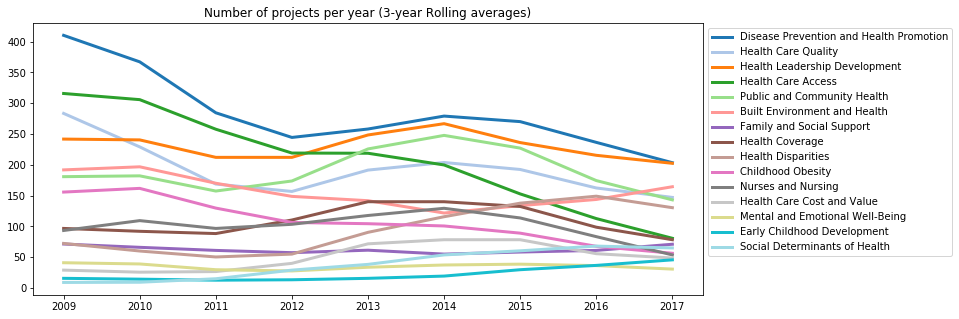

In [62]:
#We would want to look at trends: Number of appearances of topics per year
#This list comprehension

#Flattens a list of topics for a year (i.e. gives the count of topics for that year) and puts in a dataframe
year_freq = pd.DataFrame({y:pd.Series(flatten_list(list(rwj.loc[rwj['year']==y,'topics'].dropna()))).value_counts() for y in 
                          range(2007,2018)}).fillna(0).loc[real_topics].T

#Calculate rolling means
year_freq_rolling = year_freq.rolling(window=3).mean()

#Plot
fig,ax = plt.subplots(figsize=(12,5))

year_freq_rolling.plot(ax=ax,linewidth=3,cmap='tab20',title='Number of projects per year (3-year Rolling averages)')

ax.legend(bbox_to_anchor=(1,1))


It seems that system-level determinants of health (*social* and *built environment*) and *early childhood development* have become more important. *Childhood obesity* has lost importance

In [63]:
# Now I want to create similar graphs but for totals funded. How do we do this?

def filter_on_element(df,filter_variable,filter_value):
    '''
    This function takes a df where one variable filter_var is a list where every list is a nested element 
    and returns a boolean telling us if the list hasa filter value or not
    We need to run this in a df with no missing values.
    
    '''
    
    #Simple
    
    #We can't filter on missing values so we ignore them
    
    df_with_values = df.dropna(axis=0,subset=[filter_variable])
    
    #Subset the df with values on the filter variable
    filtered_df = df_with_values.loc[[filter_value in items for items in df_with_values[filter_variable]],:]

    #Return Boolean.
    return(filtered_df)
    
    

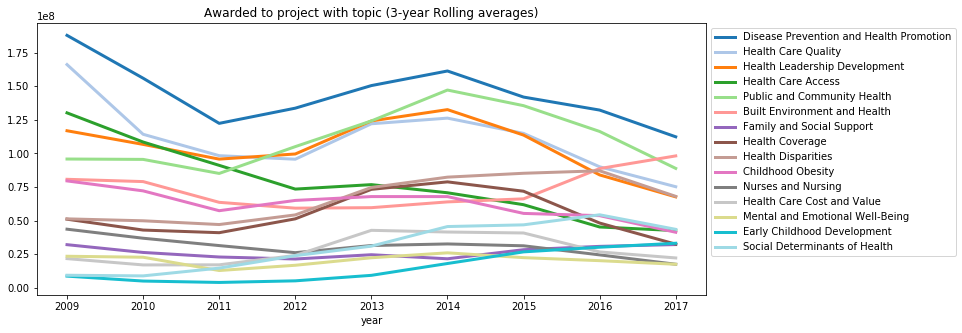

In [64]:
#This is a complicated list comprehension. Let's see how it works.
#For each year, it loops over the topics and creates a one-element named Series with the totals raised
#by projects with the topic. It concatenates it over the year, and over all years.

awarded_year_topic = pd.concat([pd.concat([pd.Series(
    filter_on_element(rwj.loc[rwj.year==y],'topics',topic).groupby('year')['awarded_$'].sum(),
    name=topic)for topic in real_topics],axis=1) for y in np.arange(2007,2018)])


#Calculate rolling means
year_awarded_rolling = awarded_year_topic.rolling(window=3).mean()

#Plot
fig,ax = plt.subplots(figsize=(12,5))

year_awarded_rolling.plot(ax=ax,linewidth=3,cmap='tab20',title='Awarded to project with topic (3-year Rolling averages)')

ax.legend(bbox_to_anchor=(1,1))



In [65]:
#Correlations between topics
#Focus on df that has topics
rwj_with_topics = rwj.dropna(axis=0,subset=['topics'])

#Create a topic boolean
topic_bool = pd.concat([pd.Series(
    [1 if top in x else 0 for x in rwj_with_topics['topics']],name=top) for top in real_topics],axis=1)

In [66]:
#Create a similarity metric and visualise
#We need to import the metrics
from sklearn.metrics.pairwise import pairwise_distances

#Similarities are the opposite of distances
topic_distances = 1- pairwise_distances(topic_bool.T,metric='jaccard')

np.fill_diagonal(topic_distances,np.nan)

/Users/grichardson/miniconda3/envs/rwjf/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Text(0.5,1,'Similarity between topics based on co-occurrence in projects')

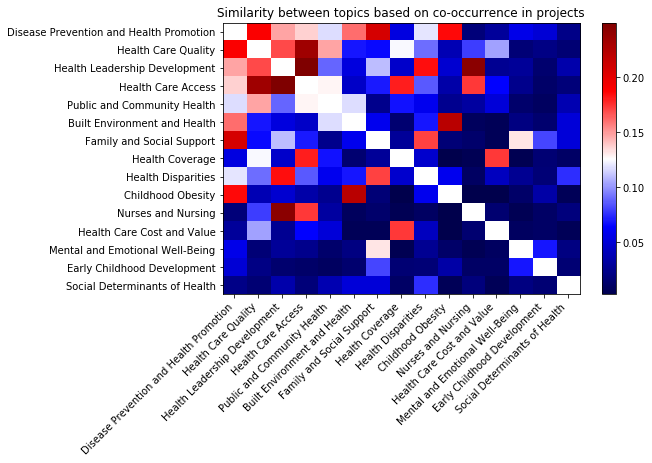

In [67]:
fig,ax = plt.subplots(figsize=(8,5))

im = ax.imshow(topic_distances,aspect='auto',cmap='seismic')
ax.set_xticks(np.arange(0,15))
ax.set_xticklabels(topic_bool.T.index,rotation=45,ha='right')

ax.set_yticks(np.arange(0,15))
ax.set_yticklabels(topic_bool.T.index)

fig.colorbar(im)

ax.set_title('Similarity between topics based on co-occurrence in projects')

Frequent topics are more similar. Hard to discern is this is an artifact of the way the projects are labelled or of their actual similarity

### Top words

And now we focus on words. This will be important because it will determine if we can use NLP on topic descriptions

In [68]:
#Remove the abouts
rwj_has_ab = rwj.dropna(axis=0,subset=['about'])


In [69]:
#Create a tokenised about
#Too many chained methods here?

#NB we are using 'threshold' to extract phrases from the corpus

rwj_has_ab['about_tokenised'] = CleanTokenize(rwj_has_ab['about']).clean().bigram(threshold=100).tokenised

rwj_has_ab['token_length'] = [len(x) for x in rwj_has_ab['about_tokenised']]

/Users/grichardson/miniconda3/envs/rwjf/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/grichardson/miniconda3/envs/rwjf/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [70]:
#What are the top words
token_freqs = pd.Series(flatten_list(rwj_has_ab['about_tokenised']),name='freq').value_counts()

#The top words are not very informative
token_freqs[:20]

health         32146
program        17248
care           14273
project        12445
support        10354
foundations     9446
research        9289
policy          8343
grant           8330
designed        8204
new             7890
community       7773
public          7252
national        6829
services        6295
nursing         5610
provide         5524
state           5507
foundation      5343
include         5325
Name: freq, dtype: int64

In [71]:
print(token_freqs.describe())

print('\n')

print(np.sum(token_freqs>10))

count    33300.000000
mean        37.043153
std        324.738448
min          1.000000
25%          1.000000
50%          2.000000
75%          9.000000
max      32146.000000
Name: freq, dtype: float64


7624


There are 55732 tokens in the corpus. The top word is health (unsurprisingly!). The median word appears 2 times
and there are 7600 tokens that appear more than 10 times. We might be able to use this in a topic modelling exercise or classification of projects into health areas.

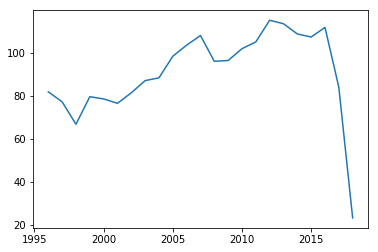

In [72]:
plt.plot(rwj_has_ab.groupby('year')['token_length'].mean())

## Exploratory topic modelling

Here we perform an exploratory topic modelling of the RWJF data. We simply want to map the activities being undertaken.

We use a script we have created with a standard LDA pipeline based on Gensim.

We will then explore the results using pyLDA viz


In [ ]:
print('running 1')

test_norm = LdaPipeline(rwj_has_ab['about_tokenised']).filter(3).process().fit_lda(
    num_topics=50,passes=20,iterations=130)

print('running 2')

test_tf = LdaPipeline(rwj_has_ab['about_tokenised']).filter(3).process().tfidf().fit_lda(
    num_topics=50,passes=20,iterations=130)

In [ ]:
test_norm.lda_topics

The topics are a bit hit and miss. We seem to be picking up health issues rather than health innovations. Perhaps we need more text?

#### Explore the data using PyLDAvis?

Unfortunately pyLDAvis doesn't seem to play nice with JupyterLabs yet. We have to display the visualisations in a different window


In [ ]:
#We will display it separately
import pyLDAvis.gensim
#pyLDAvis.enable_notebook()

#ldavis_norm = pyLDAvis.gensim.prepare(test_norm.lda_model,test_norm.corpus,test_norm.dictionary)
#pyLDAvis.save_html(ldavis_norm,fig_path+'/{date}_test_viz.html'.format(date=today_str))

#ldavis_tfidf = pyLDAvis.gensim.prepare(test_tf.lda_model,test_tf.corpus,test_tf.dictionary)
#pyLDAvis.save_html(ldavis_tfidf,fig_path+'/{date}_test_viz_tfidf.html'.format(date=today_str))

### Word embedding and document embedding analysis

Another option is to cluster the documents using Doc2vec, which will represent each project in a vector space based on the semantic similarity between its words. We can then cluster these documents and extract their top words in order to identify what they are about.

Activities: 

* Train the doc2vec model on the data.
* Cluster the docs
* Benchmark the clusters
* Label the docs

In [ ]:
from gensim.models.doc2vec import TaggedDocument
from gensim import models

#This creates a list where every element is a tag (doc title) and a list of words.
#We train the model on that
sents = [TaggedDocument(tags=[x],words=y) for x,y in zip(rwj_has_ab['title'],rwj_has_ab['about_tokenised'])]

#Train model (NB I havent tuned the d2v)
d2v = models.Doc2Vec(sents)

#Create document vector matrix
document_vectors = np.array([d2v.docvecs[t] for t in rwj_has_ab['title']])


### Clustering analysis

We want to cluster the documents.

We will build a pipeline to do this. How is it going to work?

* Initialise the class with the records (nrows = records, columns=features for clustering)
* Input the parameters for grid-search (eg number of clusters, other variables)
* Estimate silouhette scores to compare model performance across algorithms and parameters
* Return models
* Select models
* Re-run models for robust allocation of observations to clusters via community detection
* Obtain and name clusters (we will create a function that does this based on the salient terms in the cluster group)
* We can then explore the occurrence of technology areas across these clusters.
* There is no reason why we couldn't cluster the documents using other vector representations (eg topics via
LDA etc.)




In [ ]:
#Imports

from itertools import product

from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, MeanShift, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples

from yellowbrick.cluster.elbow import KElbowVisualizer
from yellowbrick.cluster.silhouette import SilhouetteVisualizer
from yellowbrick.text import TSNEVisualizer

In [ ]:
class ClusterDecider():
    '''
    This class is initialised with a df or array where: 
    
        -Rows are the elements we want to cluster
        -Columns are the features we want to use for the clustering (might have done dimensionality reduction on them)
    
    Methods:
    
        
        -grid_search method taking a list of clustering algorithms and parameters to do grid search over
        [need to remember to import clustering algorithms]. This involves creating a cartesian product
        of algorithms, fitting the models and predicting the labels.
    
        TODO -evaluation method estimates metrics of clustering performance based on silouhette score. If
        we use a word_similarity metric then we will run a custom-made algorithm that estimates the 
        average distances between salient words in each cluster compared to those in other clusters,
        
        -Return a dict with all the models we fit, their parameters and scores.
        
        We will evaluate these manually, and through Yellowbrick.
    
    '''
    
    def __init__(self,records):
        '''
        Initialise an instance of the object.
        
        '''
        
        self.records = records
    
    def grid_search(self,cluster_list):
        '''
        Loops through the cluster list and creates a grid search based on the parameters
        The parameters are in the second element of each cluster, as a tuple 
        where the first value is the name of the parameter and the rest are 
        
        
        '''
        
        #Read the records
        records = self.records
        
        #Store clustering results in a dict
        self.clustering = {}
        
        #We loop over each cluster and create combinations of parameters
        for clust in cluster_list:
            cl_algo = clust[0]
            
            #We get the cluster name in a hacky way via regex
            cluster_name = re.sub('_','',str(clust[0]).split('.')[2])
            
            print('running '+cluster_name)
            
            #This extracts the dictionary of parameters from the clust list
            #and creates a cartesian product (all possible combinations of values)
            par_comb = list(product(*clust[1].values()))
            
            #And this turns the cartesian product into a list of dicts with named parameters
            par_list = [{par:val for par,val in zip(clust[1].keys(),par_vals)} for par_vals in par_comb]
            
            #Now we can loop over this list to to run each cluster:
            
            for parameters in par_list:
                #Initialise the cluster and set parameters
                cl = cl_algo().set_params(**parameters)
                
                #Fit the cluster
                cl.fit(records)
                
                #We also want to estimate the silouhette scores etc.
                sil_score = silhouette_score(records,cl.labels_)
                
                #Store results
                self.clustering['_'.join([cluster_name]+[k+':'+str(v) for k,v in parameters.items()])]=[
                    cl,
                    cl.labels_,
                    sil_score]
            
                #We also want to estimate the silouhette scores etc.   
                
        return(self)
                
    def cluster_scores(self):
        '''
        Takes the scores from the clustering algorithms and plots them
        
        '''
        
        #Extract scores
        scores = pd.DataFrame([{'name':k,'score':v[-1]} for k,v in self.clustering.items()]).sort_values('score')   
        
        fig,ax = plt.subplots()

        scores['score'].plot.bar(ax=ax,color='blue')

        ax.set_xticklabels(scores['name'])
        ax.set_title('Silouhette scores')
        
        return(ax)
        
        
        

In [ ]:
def visual_validation(cluster_labels,sort_results=True,print_n='all',subset=False):
    '''
    This function takes a list of cluster labels and returns some information about their content:
    Number of observations, titles, distinctive words...
    
    We can ask it to sort the data (start with the biggest clusters) and limit the numbers
    that are printed (if we have lots). We can also ask it to print a subset of the clusters
    
    '''
    
    rwj_clust = pd.concat([rwj_has_ab[['title','about_tokenised']]])
    rwj_clust['cluster'] = cluster_labels

    if sort_results == True:
    #If we want to present the results labelled
        cluster_labels = pd.Series(cluster_labels).value_counts().index
    
    else:
        cluster_labels = sorted(list(set(cluster_labels)))
    
    
    if subset!=False:
        cluster_labels = [x for x in cluster_labels if x in subset]
    
    if print_n!='all':
        '''
        Select how many to print
        
        '''
        
        cluster_labels = cluster_labels[:print_n]
        
    
    for x in cluster_labels:


        rel = rwj_clust.loc[rwj_clust['cluster']==x]

        print(x)
        print(len(rel))

        print(rel.head())

        print('\n')

        el_freq = pd.Series(flatten_list(rel['about_tokenised']),name=x).value_counts()[:50]

        norm_freq = pd.concat([el_freq,token_freqs],axis=1)
        norm_freq['norm'] = norm_freq[x]/norm_freq['freq']

        print(norm_freq.sort_values('norm',ascending=False)[:10])    

        print('\n')

In [ ]:
cd = ClusterDecider(document_vectors)

clusts= [
    #[SpectralClustering,{'n_clusters':np.arange(10,20,2)}],
    [KMeans,{'n_clusters':np.arange(15,40,2)}],
    #[DBSCAN,{}],
    #[MeanShift,{'cluster_all':[True,False]}],
    #[AffinityPropagation,{}]
         ]

cd.grid_search(cluster_list=clusts)

cd.cluster_scores()

In [ ]:
sel_labs = cd.clustering['kmeans_n_clusters:15'][1]

visual_validation(sel_labs,print_n=10)

### Additional processing

Currently, the clustering algorithm is picking up programmes with repeated titles.

We want to remove those. How do we do it?

Idea: cluster documents on their titles using doc2vec and then identify which clusters are
most homogeneous (eg average levehnstein distances between all components is lower. 
We then allocate all documents in 'programme clusters' in there, and redo the clustering

In [ ]:
#We tokenise titles
titles_tokenised = CleanTokenize(rwj_has_ab['title']).clean().bigram(threshold=100).tokenised

#We train the model on that
sents_dedupe = [TaggedDocument(tags=[x],words=y) for x,y in zip(rwj_has_ab['title'],titles_tokenised)]

#Train model (NB I havent tuned the d2v)
d2v_title = models.Doc2Vec(sents_dedupe)

#Create document vector matrix
document_vectors_titles = np.array([d2v_title.docvecs[t] for t in rwj_has_ab['title']])

In [ ]:
#Run the clustering as before
cd_titles = ClusterDecider(document_vectors_titles)

clusts= [
    #[SpectralClustering,{'n_clusters':np.arange(10,20,2)}],
    [KMeans,{'n_clusters':np.arange(30,80,5)}],
    #[DBSCAN,{}],
    #[MeanShift,{'cluster_all':[True,False]}],
    #[AffinityPropagation,{}]
         ]

cd_titles.grid_search(cluster_list=clusts)

cd_titles.cluster_scores()

We want to allocate 'repeated' clusters (with the same title) to the same cluster and normalise.

Otherwise any cluster analysis or topic modelling we do is going to keep picking up those repeated clusters

We identify what these clusters are with the mean/variance distance between observations and the cluster centroid (clusters with large/variant distances will be more dispersed than those with small/invariant distances, and less likely to contain repeated programmes

In [ ]:
from sklearn.metrics import pairwise


In [ ]:
test_cluster = cd_titles.clustering['kmeans_n_clusters:60'][0]

#For each cluster, we will calculate distance mean and variance between all observations and the centre.

container = []

for clust in list(set(test_cluster.labels_)):
    #print(clust)
    # Find the document vectors in the cluster
    
    #Subset the document vectors to get those in the cluster
    vectors = np.array(document_vectors_titles)[[val==clust for val in test_cluster.labels_],:]
    
    size = len(vectors)
    
    #print(vectors.shape)
    
    #Extract the centroid
    centroid = test_cluster.cluster_centers_[x]
    
    #print(centroid)
    
    #Calculate all distances
    distances = pairwise.cosine_distances(vectors,centroid.reshape(1,-1))
    
    #print(distances.shape)
    
    #Calculate distance mean and variance
    median = np.median(distances)
    
    variance = np.round(np.var(distances),3)
    
    container.append([clust,size,median,variance])

In [ ]:
zero_var = [x[0] for x in container if x[3]==0]
non_zero_var = [x[0] for x in container if x[0] not in zero_var]

#non_zero_var = [x[0] for x in container if x[0] not in zero_var]

In [ ]:
visual_validation(cd_titles.clustering['kmeans_n_clusters:60'][1],sort_results=False,
                  subset=zero_var)

Ok - this seems to be picking up the 'duplicate' programmes. Maybe we can wrap them up together and redo the 
cluster analysis